# Pipeline for analysing open clusters based on Gaia DR2 data

## 1 - Libraries

In [1]:
#%matplotlib notebook

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy
import astropy.stats as ap

from math import pi, ceil, floor
from astropy import units
from astropy.table import Table
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
from IPython.display import display, HTML

## 2 - Query Gaia EDR3 Catalog

In [12]:
# Gaia EDR3 catalog on VizieR
# see https://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=I/345/gaia2
cat = '	I/350/gaiaedr3'
cols = ['_r', 'EDR3Name', 'RAdeg', 'DEdeg', 'Plx', 'e_Plx', 'pmRA', 'pmDE', 'Gmag', 'BP-G']
row_lim = 1000
timeout = 600
uns = [['h','m','s'],['d','m','s']]

#Query the GDR2 data for one cluster
def query(name, ra_deg, de_deg, rad_deg, filter_map, max_stars = 1000):
    print("Querying VizieR for %s ..." % name)
    coo = SkyCoord(ra = ra_deg*units.degree, dec = de_deg*units.degree, frame = 'icrs')
    viz = Vizier(columns = cols, column_filters = filter_map, row_limit = row_lim, timeout = timeout)
    viz_res = viz.query_region(coo, radius = rad_deg*units.degree, catalog = cat)
    if viz_res == None or len(viz_res) == 0:
        print(viz_res)
        return pd.DataFrame() #Empty Dataframe
    df = viz_res[0].to_pandas()
    df = df.set_index('EDR3Name')
    df = df.sort_values(by='Gmag')
    df = df[:max_stars]
    df = df.sort_values(by='_r')
    if not df.empty:
        #display(df.head())
        display(df.describe())
    else:
        print('Empty dataframe! - try again with another set of parameters')
    return df

# convert sexagesimal to decimal coordinates
def convert(_ra, _dec, diam):
    comps = list(zip(_ra.split(' '),uns[0]))
    ra = ''.join([item for sublist in comps for item in sublist])
    comps = list(zip(_dec.split(' '),uns[1]))
    dec = ''.join([item for sublist in comps for item in sublist])
    c = SkyCoord(ra, dec, frame='icrs')
    return c.ra.value, c.dec.value, diam / 120

filters = {'Plx' : '-0.3..5.5', 'e_Plx' : '<2', 'pmRA' : '-10..10', 'pmDE' : '-10..-3', 'Gmag' : '<19.5'}

# PUT THE INPUT HERE IF YOU WANT TO ENTER SEXAGESIMAL COORDINATES AND DIAM IN ARCMIN
#cl_name, cl_ra_sexa, cl_de_sexa, diam_arcmin = 'Alessi_62', '18 56 06.2', '+21 35 49', 36

cl_name, cl_ra_sexa, cl_de_sexa, diam_arcmin = 'Ryu 768',     '18 25 03.0', '-13 09 43', 1.5 #3780

cl_ra, cl_de, radius = convert(cl_ra_sexa, cl_de_sexa, diam_arcmin)

# PUT THE INPUT HERE IF YOU WANT TO ENTER DECIMAL COORDINATES IN DEGREES AND RADIUS IN DEGREES
#cl_name, cl_ra, cl_de, radius = 'Alessi_62', 284.026, +21.597, 0.256

#cl_name, cl_ra, cl_de, radius = 'Kronberger_100', 143.977917, -54.030278,  0.0133
#cl_name, cl_ra, cl_de, radius = 'Kronberger_106', 156.838333, -55.111389,  0.02410
#cl_name, cl_ra, cl_de, radius = 'Kronberger_113', 160.791250, -62.669722,  0.01000
#cl_name, cl_ra, cl_de, radius = 'Kronberger_119', 161.812500, -63.327778,  0.02
#cl_name, cl_ra, cl_de, radius = 'Kronberger_134', 170.884167, -60.533056,  0.015
#cl_name, cl_ra, cl_de, radius = 'Kronberger_137', 172.900833, -61.525278,  0.0177
#cl_name, cl_ra, cl_de, radius = 'Kronberger_143', 179.427500, -64.177778,  0.015
#cl_name, cl_ra, cl_de, radius = 'Patchick_121',   144.839583, -52.250278,  0.03 #0.01167
#cl_name, cl_ra, cl_de, radius = 'Patchick_122',   145.627917, -52.428056,  0.0137
#cl_name, cl_ra, cl_de, radius = 'Strottner_1',    146.838750, -53.503889,  0.0115
#cl_name, cl_ra, cl_de, radius = 'Kronberger_122', 165.124167, -58.841944,  0.027
#cl_name, cl_ra, cl_de, radius = 'Patchick_123',   182.579167, -63.879167,  0.012

df = query(cl_name, cl_ra, cl_de, radius, filters)
#df.head

Querying VizieR for Ryu 768 ...


,_r,_RAJ2000,_DEJ2000,Plx,e_Plx,pmRA,pmDE,Gmag,BP-G
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000
mean,0.008853,276.263017,-13.159714,0.438920,0.273110,-1.581700,-4.81040,18.410444,1.533055
std,0.002580,0.006828,0.006628,0.457390,0.156441,2.421522,1.76388,0.942373,0.360604
min,0.003217,276.252903,-13.171443,-0.208700,0.093200,-7.116000,-9.07900,17.057217,0.891253
25%,0.007660,276.258231,-13.164460,0.048350,0.126550,-2.254750,-5.17950,17.574194,1.292764
50%,0.009049,276.262397,-13.156177,0.506700,0.243000,-1.403500,-4.29250,18.595451,1.562499
75%,0.010701,276.268323,-13.154420,0.696425,0.410125,-0.854000,-3.80250,19.173977,1.736334
max,0.011689,276.272326,-13.153929,1.170200,0.514700,2.496000,-3.19200,19.475218,2.154236


## 3 - VPD scatter plot and 2D Histogram (returning PMs for the bin with highest count)

Ryu 768        ;  0.519; 0.288;  -0.863;  0.101;  -3.661;  0.458;    4; 17.08..19.30


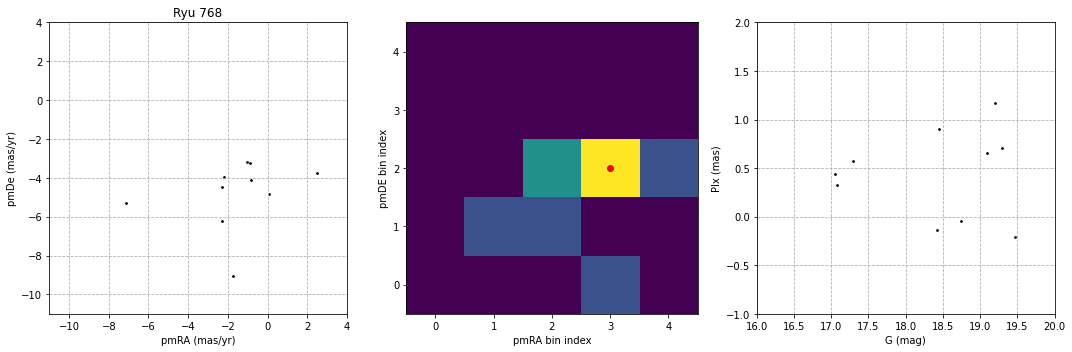

In [13]:
## determine limits for dimensioning the VPD
def pm_limits(pmras, pmdes):
    max_pm = ceil(np.max([np.max(pmras), np.max(pmdes)]) + 1)
    min_pm = floor(np.min([np.min(pmras), np.min(pmdes)]) - 1)
    return min_pm, max_pm
 
def plx_limits(plxs):
    max_plx = ceil(np.max(plxs) + 0.25)
    min_plx = floor(np.min(plxs))
    return min_plx, max_plx

def mag_limits(gmags):
    max_gmag = ceil(np.max(gmags) + 0.5)
    min_gmag = floor(np.min(gmags) - 0.5)
    return min_gmag, max_gmag

# Build a VPD (Vector Proper Motion Diagram) scatter plot
def plot_VPD(data, title):
    pmras = data['pmRA']
    pmdes = data['pmDE']
    xs, ys = pmras, pmdes
    plt.title(title)
    plt.xlabel('pmRA (mas/yr)')
    plt.ylabel('pmDe (mas/yr)')
    min_pm, max_pm = pm_limits(pmras, pmdes)
    plt.xlim(min_pm, max_pm)
    plt.ylim(min_pm, max_pm)
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

# Calculates the median parallax of the stars within <limit> of the estimated pms
def calculate_estimates(data, est_pmra, est_pmde, limit = 1.5):
    def filter_pms(pmra, pmde):
        return (abs(est_pmra - pmra) < limit) and (abs(est_pmde - pmde) < limit)
    filter_fn = lambda x: filter_pms(x['pmRA'], x['pmDE'])
    data = data[data.apply(filter_fn, axis = 1)]
    plxs = data['Plx']
    pmra = data['pmRA']
    pmde = data['pmDE']
    gmag = data['Gmag']
    plx, err_plx = np.median(plxs), ap.median_absolute_deviation(plxs)
    pmra, err_pmra = np.median(pmra), ap.median_absolute_deviation(pmra)
    pmde, err_pmde = np.median(pmde), ap.median_absolute_deviation(pmde)
    gmin, gmax = np.min(gmag), np.max(gmag)
    return data, plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, len(plxs)

# Build 2D histogram for proper motions and returns average PMs for the bin with the highest count
def plot_pm_hist(data, num_bins = 5):
    xs = data['pmRA']
    ys = data['pmDE']
    min_pm, max_pm = pm_limits(xs, ys)
    _range = [[min_pm, max_pm], [min_pm, max_pm]]
    counts, xedges, yedges = np.histogram2d(xs, ys, bins = num_bins, range = _range)
    x_ind, y_ind = np.unravel_index(np.argmax(counts), counts.shape)
    est_pmRA = (xedges[x_ind] + xedges[x_ind+1]) / 2
    est_pmDe = (yedges[y_ind] + yedges[y_ind+1]) / 2
    plt.imshow(counts.T, origin = 'lower')
    plt.xlabel('pmRA bin index')
    plt.ylabel('pmDE bin index')
    plt.plot(x_ind, y_ind, 'or')
    #stars, plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, n = calculate_estimates(data, est_pmRA, est_pmDe)
    #return plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, n
    return calculate_estimates(data, est_pmRA, est_pmDe)

# Build G mag X Parallax scatter plot
def plot_mag_par(data):
    plxs = data['Plx']
    gmags = data['Gmag']
    min_gmag, max_gmag = mag_limits(gmags)
    min_plx, max_plx = plx_limits(plxs)
    xs, ys = gmags, plxs
    plt.xlabel('G (mag)')
    plt.ylabel('Plx (mas)')
    plt.xlim(min_gmag, max_gmag)
    plt.ylim(min_plx, max_plx)
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

# plot both graphics side-by-side
def plot_step1(data, cl_name):
    fig = plt.figure(figsize=(15,5))
    plt.subplot(131)
    plot_VPD(data, cl_name)
    plt.subplot(132)
    stars, plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, n = plot_pm_hist(data)
    plt.subplot(133)
    plot_mag_par(data)
    plt.tight_layout()
    return stars, plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, n

stars, est_plx, err_plx, est_pmRA, err_pmRA, est_pmDe, err_pmDe, gmin, gmax, n = plot_step1(df, cl_name)
#estimates = f'{cl_name:<15}; {cl_ra:9.6f}; {cl_de:+9.6f}; {radius:8.5f};  '
estimates = f'{cl_name:<15};  '
estimates += f'{est_plx:5.3f}; {err_plx:5.3f}; {est_pmRA:7.3f};{err_pmRA:7.3f}; {est_pmDe:7.3f};{err_pmDe:7.3f};'
estimates += f'{n:>5}; {gmin:5.2f}..{gmax:5.2f}'
print(estimates)

## 4 - Query another area constrained by the estimated values

Querying VizieR for Sct I Assoc ...


,_r,_RAJ2000,_DEJ2000,Plx,e_Plx,pmRA,pmDE,Gmag,BP-G
count,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,0.403073,282.753115,-6.237479,0.396081,0.025316,-1.545027,-4.206637,11.681900,0.443313
std,0.046058,0.091438,0.102557,0.044960,0.007788,0.160755,0.116886,0.605418,0.436444
min,0.245724,282.239963,-6.344814,0.284700,0.015400,-1.971000,-4.570000,8.363688,0.111666
25%,0.381940,282.742920,-6.283188,0.369200,0.020500,-1.661000,-4.279000,11.312872,0.190724
50%,0.417302,282.767305,-6.260437,0.393900,0.023500,-1.562000,-4.206000,11.722395,0.222181
75%,0.432882,282.789462,-6.229227,0.427500,0.028100,-1.427000,-4.126000,12.150220,0.776070
max,0.486175,282.978805,-5.565963,0.505100,0.057100,-1.102000,-3.847000,12.498269,2.883257


,_r,_RAJ2000,_DEJ2000,Plx,e_Plx,pmRA,pmDE,Gmag,BP-G
EDR3Name,,,,,,,,,
Gaia EDR3 4252518901680682368,0.245724,282.706713,-6.108277,0.4196,0.0226,-1.519,-4.215,12.496949,0.227386
Gaia EDR3 4252520134217124736,0.261623,282.627720,-6.149964,0.4351,0.0234,-1.217,-4.409,12.493246,0.886743
Gaia EDR3 4254020417838597760,0.273299,282.801949,-6.066758,0.3757,0.0365,-1.111,-4.205,11.255796,1.591631
Gaia EDR3 4252518278791248896,0.282495,282.765162,-6.114497,0.3999,0.0176,-1.494,-4.313,12.028240,0.292546
Gaia EDR3 4252518450589945856,0.285843,282.697629,-6.156525,0.3367,0.0238,-1.530,-4.168,11.486315,0.111666
Gaia EDR3 4254021075051688960,0.295269,282.856964,-6.023345,0.4369,0.0158,-1.475,-4.336,10.448225,0.385652
Gaia EDR3 4254801174170800384,0.300552,282.460515,-5.620069,0.3621,0.0160,-1.661,-4.083,12.188800,1.229398
Gaia EDR3 4252517797754916224,0.303364,282.748773,-6.150853,0.4399,0.0249,-1.460,-4.256,12.432179,0.165233
Gaia EDR3 4252516015462491136,0.325333,282.690126,-6.201063,0.3865,0.0217,-1.718,-4.148,11.113221,0.794032


(                                     _r    _RAJ2000  _DEJ2000     Plx   e_Plx  \
 EDR3Name                                                                        
 Gaia EDR3 4252518901680682368  0.245724  282.706713 -6.108277  0.4196  0.0226   
 Gaia EDR3 4252520134217124736  0.261623  282.627720 -6.149964  0.4351  0.0234   
 Gaia EDR3 4254020417838597760  0.273299  282.801949 -6.066758  0.3757  0.0365   
 Gaia EDR3 4252518278791248896  0.282495  282.765162 -6.114497  0.3999  0.0176   
 Gaia EDR3 4252518450589945856  0.285843  282.697629 -6.156525  0.3367  0.0238   
 ...                                 ...         ...       ...     ...     ...   
 Gaia EDR3 4252499557111781120  0.469362  282.794287 -6.314737  0.2847  0.0207   
 Gaia EDR3 4252499591505213952  0.469372  282.815466 -6.304083  0.4261  0.0303   
 Gaia EDR3 4252499552745435264  0.470994  282.795480 -6.315980  0.4416  0.0518   
 Gaia EDR3 4252499591505206144  0.473872  282.813939 -6.309991  0.4275  0.0200   
 Gaia EDR3 42524

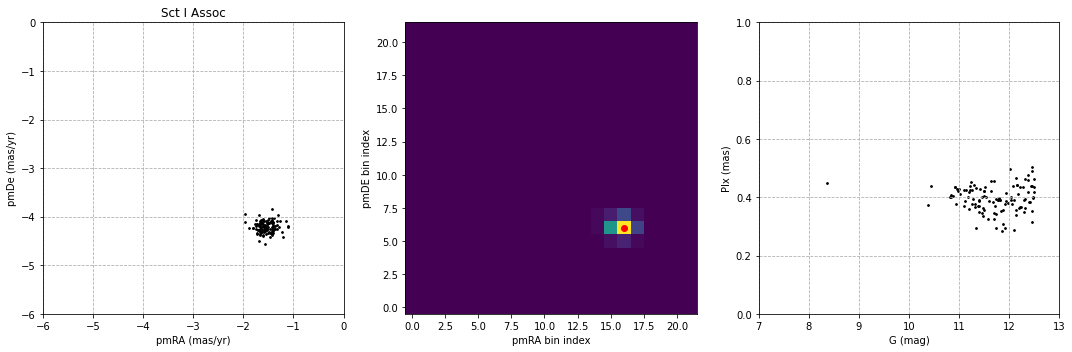

In [437]:
def constrained_query(name, ra_deg, de_deg, rad, est_pmRA, est_pmDe, est_plx, mul_pm=4, mul_px=4, mul_rad=1):
    plx_lim = (est_plx - mul_px*err_plx, est_plx + mul_px*err_plx)
    plx_range = f'{plx_lim[0]:.2f}..{plx_lim[1]:.2f}'
    pmRA_lim = (est_pmRA - mul_pm*err_pmRA, est_pmRA + mul_pm*err_pmRA)
    pmRA_range = f'{pmRA_lim[0]:.2f}..{pmRA_lim[1]:.2f}'
    pmDe_lim = (est_pmDe - mul_pm*err_pmDe, est_pmDe + mul_pm*err_pmDe)
    pmDe_range = f'{pmDe_lim[0]:.2f}..{pmDe_lim[1]:.2f}'
    gmag_range = f'{gmin:.2f}..{gmax:.2f}'
    filters2 = {'Plx' : plx_range, 'pmRA' : pmRA_range, 'pmDE' : pmDe_range, 'Gmag' : gmag_range}
    #print(filters2)
    return query(name, ra_deg, de_deg, rad*mul_rad, filters2, max_stars = row_lim)
    
df2 = constrained_query(cl_name, cl_ra, cl_de, radius, est_pmRA, est_pmDe, est_plx)

df2.head
display(HTML(df2.to_html()))

plot_step1(df2, cl_name)

## 5 - Chart  and RDP scatter plot (constrained by the estimated values)

(0.244, 0.27]      2
(0.27, 0.294]      3
(0.294, 0.318]     3
(0.318, 0.342]     1
(0.342, 0.366]    10
(0.366, 0.39]     13
(0.39, 0.414]     21
(0.414, 0.438]    42
(0.438, 0.462]    13
(0.462, 0.486]     5
Name: _r, dtype: int64


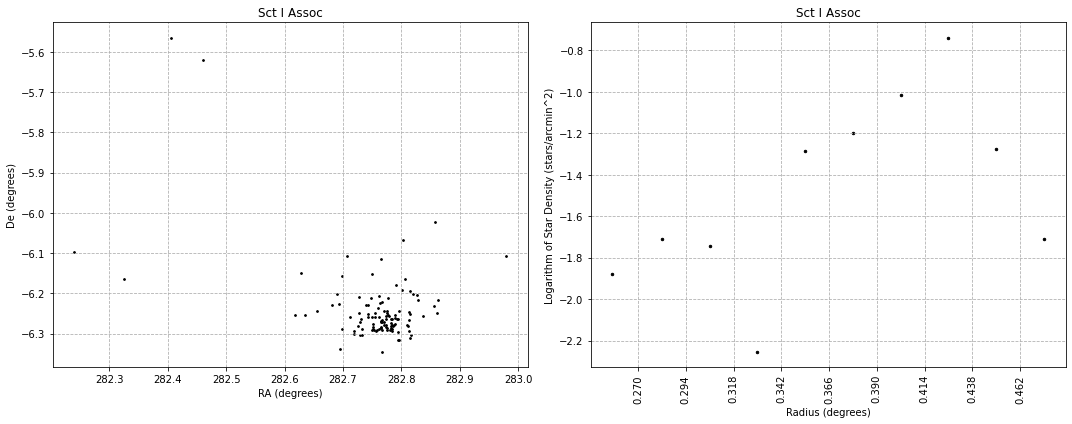

In [438]:

# Build chart scatter plot
def plot_chart(data, title):
    xs, ys = data['_RAJ2000'], data['_DEJ2000']
    plt.title(title)
    plt.xlabel('RA (degrees)')
    plt.ylabel('De (degrees)')
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

# Build RDP (Radial Density Profile) scatter plot
def plot_RDP(data, title = None):
    bins = data['_r'].value_counts(bins=10).sort_index()
    intervals = bins.index.to_tuples()
    midpoints = [i.mid for i in bins.index]
    counts = bins.values
    zipped = tuple(zip(intervals, midpoints, counts))
    densities = [count / ring_area(inner*60, outer*60) for ((inner, outer), midpoint, count) in zipped]
    log_dens = [np.log10(dens) if dens > 0 else 0 for dens in densities]
    print(bins)
    #print(intervals)
    #print(midpoints)
    #print(counts)
    #print(zipped)
    plt.grid(True, linestyle='dashed')
    plt.title(title)
    plt.xlabel('Radius (degrees)')
    plt.xticks([i for i,j in intervals], rotation='vertical')
    plt.ylabel('Logarithm of Star Density (stars/arcmin^2)')
    plt.scatter(midpoints, log_dens, s=6, color='black')

# plot both graphics side-by-side
def plot_step2(data, cl_name):
    fig = plt.figure(figsize=(15,6))
    plt.subplot(121)
    plot_chart(data, cl_name)
    plt.subplot(122)
    plot_RDP(data, cl_name)
    plt.tight_layout()

def ring_area(inner_rad, outer_rad):
    return pi * (outer_rad**2 - inner_rad**2)
    
plot_step2(df2, cl_name)


## 6 - CMD

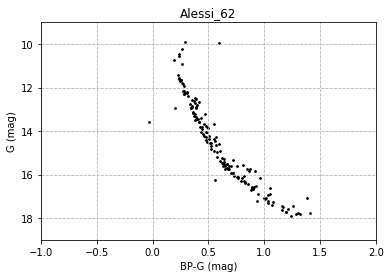

In [210]:
# Build G mag X Parallax scatter plot
def plot_mag_par(data, title = None):
    plxs = data['Plx']
    gmags = data['Gmag']
    min_gmag, max_gmag = mag_limits(gmags)
    min_plx, max_plx = plx_limits(plxs)
    xs, ys = gmags, plxs
    if title:
        plt.title(title)
    plt.xlabel('G (mag)')
    plt.ylabel('Plx (mas)')
    plt.xlim(min_gmag, max_gmag)
    plt.ylim(min_plx, max_plx)
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

# Build CMD (Color-Magnitude Diagram) scatter plot
def plot_CMD(data, title = None):
    gmags = data['Gmag']
    colors = data['BP-G']
    min_gmag, max_gmag = mag_limits(gmags)
    min_color, max_color = mag_limits(colors)
    xs, ys = colors, gmags
    if title:
        plt.title(title)
    plt.xlabel('BP-G (mag)')
    plt.ylabel('G (mag)')
    plt.xlim(min_color, max_color)
    plt.ylim(max_gmag, min_gmag)
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

chosen_lim_radius = 1.15 #choose one based on the RDP printed above
df3 = df2[df2['_r'] < chosen_lim_radius]
#plot_mag_par(df3, cl_name)
plot_CMD(df3, cl_name)
